# Estimating internal variability
This notebook visualises the initial condition ensembles and calculates the variance of each ensemble.
We assume that the variance at one point in parameter space is similar to the variance at a point close to the first point.
The variances are saved as a vector, where the value for each training point is either the calculated variance at that point, or the closest calculated variance by Euclidean distance.
This vector is then applied as a nugget term in the emulate_and_validate notebook.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
import scipy.stats as sts
import sys
sys.path.append('py_scripts')
import ppe_class_lib as ppe_lib

In [28]:
SMALL_SIZE = 20
LARGE_SIZE = 24
MEDIUM_SIZE = 22
legendfont=15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=LARGE_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=LARGE_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE-0.5)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)  # fontsize of the figure title

def plot_ice_cf_timeseries(ax, member, title=None):
    member.cloud_fraction.plot(ax=ax, c='black', alpha=0.5)
    xlim_upper = 100

    ax.plot((member.sc_time, member.sc_time), (0,1), linestyle=(0, (5, 10)), alpha=0.5, c='black',)
    # ax.plot((member.cu_time, member.cu_time), (0,1), linestyle=(0, (5, 10)), alpha=0.5, c='black', label = "CF intersection with thresholds")
    sc_line, = ax.plot((0,xlim_upper),(0.9,0.9), ':', c='black')
    cu_line, = ax.plot((0,xlim_upper),(0.55,0.55), '--', c='black')

    ax.set_ylim((0,1.05))
    ax.set_xlim((0,xlim_upper))
    ax.set_ylabel("Cloud fraction")
    ax.set_xlabel("Simulation time (hrs)")
    ax.set_title(title)
    return ax, sc_line, cu_line

    
def calculate_residuals(array1d):
    mean = np.nanmean(array1d)
    residuals = np.array([(val - mean) for val in array1d])
    return residuals

def sample_var(array1d):
    mean       = np.nanmean(array1d)
    deviations = [(element - mean)**2 for element in array1d]
    variance   = np.nansum(deviations)/(len(array1d)-1)
    return variance

def ppe_residuals(ppe_predictions, ppe_actual):
    return [(actual - pred) for pred, actual in zip(ppe_predictions, ppe_actual)]

def plot_nugget_hists(actual_data, loo_means, ice_data, ice_residuals, ax, xlim):
    # randomly select different combinations of the ice to create a variety of possible distributions to sample from
    reps = 50
    surface_res = np.empty((len(actual_data), reps))
    #random.seed(11)
    for rep in range(reps):
        for i,j in enumerate([0, 12, 25, 28]):
            top = 3 if j==0 else 4
            actual_data[j] = ice_data[i][random.randint(0, top)]
        surface_res[:,rep] = ppe_residuals(actual_data, loo_means)

    # average over each ensemble point and insert into data?
    for i, row in zip([0, 12, 25, 28], ice_data):
        actual_data[i] = np.nanmean(row)
    surface_mean_ens_res = ppe_residuals(actual_data, loo_means)
    
    # create equal bins for both data
    surface_range = (np.min(surface_res), np.max(surface_res))
    ice_range = (np.min(ice_residuals), np.max(ice_residuals))
    max_range = np.argmax([ice_range[1]-ice_range[0], surface_range[1]-surface_range[0]])
    bin_range = ice_range if max_range == 0 else surface_range
    #bins = np.linspace(bin_range[0], bin_range[1], 20)
    bins = np.linspace(xlim[0], xlim[1], 20)

    # find means of the distributions
    distro_arr = np.empty((len(bins)-1,reps))
    for i,col in enumerate(surface_res.transpose()):
        freq, bins_array = np.histogram(col,bins=bins,density=True)
        distro_arr[:,i] = freq
    n2 = np.mean(distro_arr,axis=1)

    # plot ice residuals histogram and the average distribution from the surface residuals
    n1, bin_array, p1 = ax.hist(ice_residuals, alpha=0.5, color="#CE8964",  bins=bins, density=True, label="Model",orientation='horizontal')
    ax.barh(bin_array[:-1], n2, height=np.diff(bin_array), alpha=0.5, color="#2D93AD",align='edge', label="Emulator")

    print("n1 sum: ", sum(n1))
    print("n2 sum: ", sum(n2))
    minimums = [min(x,y) for x,y in zip(n1,n2)]
    overlap = sum(minimums)/sum(n1) # divided to make a fraction
    ice_residuals_clean = [x for x in ice_residuals if not np.isnan(x)]
    kstat = sts.ks_2samp(ice_residuals_clean, surface_mean_ens_res)
    ax.text(1.05,0.32, 'KS p-val: {:0.2f}'.format(kstat[1]), fontsize=legendfont, transform=ax.transAxes, horizontalalignment="left", verticalalignment="top")
    ax.text(1.05,0.24, 'Overlap: {:0.2f}'.format(overlap), fontsize=legendfont, transform=ax.transAxes, horizontalalignment="left", verticalalignment="top")
    #ax.set_xlim(xlim)
    return ax, surface_res, kstat

def plot_nugget_validation(output_data, loo_means, ensembles_array, residuals):  
    fig = plt.figure(figsize=(8, 9.5))
    gs = fig.add_gridspec(2, 2,  width_ratios=(3, 1),hspace=0.06,wspace=0.08,top=0.95,left=0.15,right=0.95,bottom=0.12)
    ax1 = fig.add_subplot(gs[1, 0])
    ax0 = fig.add_subplot(gs[0, 0], sharex=ax1)
    ax2 = fig.add_subplot(gs[1, 1], sharey=ax1)

    means = []
    for ens_row, res_row in zip(ensembles_array, residuals):
        mean = np.nanmean(ens_row)
        means.append(mean)
        ax0.scatter([mean]*len(ens_row), ens_row, c='black',s=180, marker='s', alpha=0.3)
        ax1.scatter([mean]*len(ens_row), res_row, c='black',s=180, marker='s', alpha=0.3)
    
    ex_ind = np.argmax([abs(np.nanmin(residuals)), abs(np.nanmax(residuals))])
    ex = abs(np.nanmin(residuals)) if ex_ind == 0 else abs(np.nanmax(residuals))
    res_ylim = (-ex*1.1,ex*1.1)
    mean_xlim = (0,np.nanmax(ensembles_array*1.1))
    ax0.set_ylim(mean_xlim)
    ax1.set_ylim(res_ylim)
    [ax.set_xlim(mean_xlim) for ax in [ax0, ax1]]

    ice_residuals_1dlist = np.reshape(residuals, np.size(residuals))
    ax, surface_res, kstat = plot_nugget_hists(
                                output_data, 
                                loo_means, 
                                ensembles_array,
                                ice_residuals_1dlist,
                                ax2, res_ylim)

    ax0.set_ylabel("Ensemble mean")
    ax1.set_xlabel("Ensemble mean")
    ax1.set_ylabel("Residuals")
    ax2.set_xlabel("Freq.")
    
    ax0.tick_params(axis="x", labelbottom=False)
    ax2.tick_params(axis="y", labelleft=False)
    ax0.set_xticks(means)
    ax1.set_xticks(means)
    ax1.set_xticklabels([f'{val:0.0f}' for val in means], fontsize=SMALL_SIZE)

    ax0.text(0.92,0.9,"a",transform=ax0.transAxes,fontsize=SMALL_SIZE)
    ax1.text(0.92,0.9,"b",transform=ax1.transAxes,fontsize=SMALL_SIZE)
    ax2.text(0.8,0.9,"c",transform=ax2.transAxes,fontsize=SMALL_SIZE)
    
    ax2.legend(loc=(1.001, 0), handlelength=0.75, frameon=False, fontsize=15, handletextpad=0.13)
    return fig, kstat

## Load PPE with initial condition ensembles and check indices

In [4]:
ppe = ppe_lib.Ensemble(include_spinup=False)
ppe.find_initial_ssts()
ppe.load_ice_members()

In [5]:
i=0
for key in ppe.member_sct_keys:
    member = vars(ppe)[key]
    if member.initial_sst < 296:
        if key in ppe.ice_dict_keys.keys():
            print(f"{key} index = {i}")
        i+=1

em0 index = 0
em34 index = 12
em80 index = 25
em85 index = 28


## Visualise ensemble timeseries

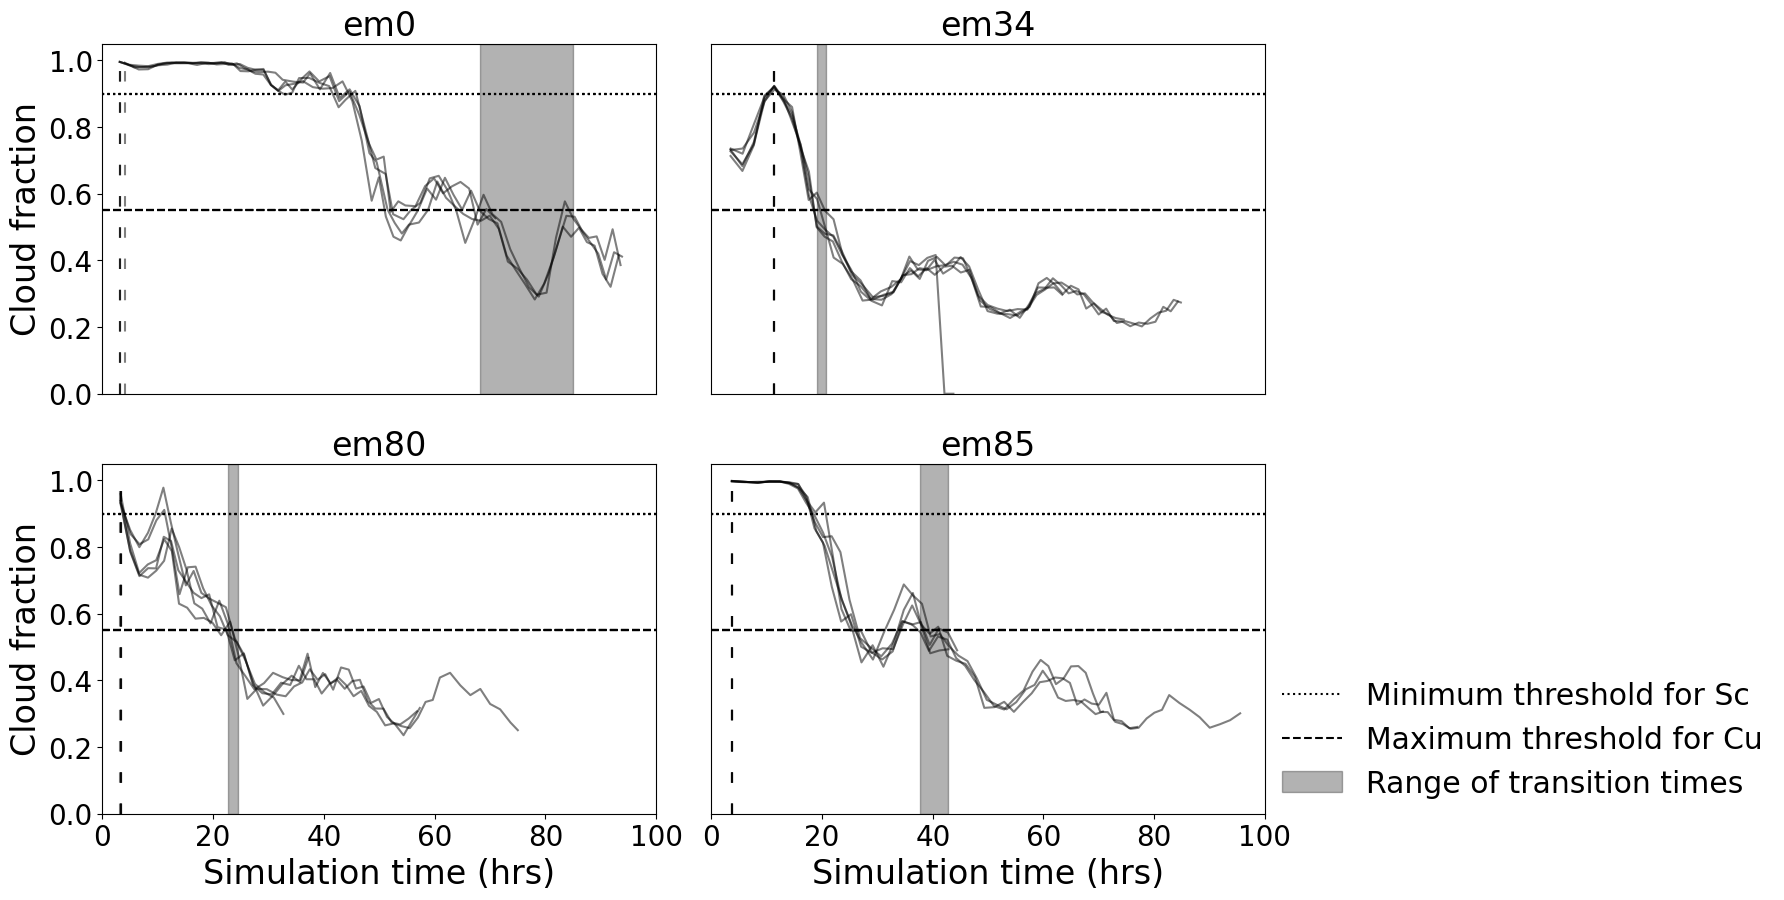

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
plt.subplots_adjust(wspace=0.1)
axes_list = [a for ax in axes for a in ax]

transition_time_arr = np.zeros((4,5))
rwp_mean_arr = np.zeros((4,5))
i = 0
for (root_key, key_list), a in zip(ppe.ice_dict_keys.items(), axes_list):
    transition_time = []
    rwp_mean = []
    for key in key_list:
        member = vars(ppe)[key]
        a, sc_line, cu_line = plot_ice_cf_timeseries(a, member, title=root_key)
        transition_time.append(member.cu_time)
        rwp_mean.append(member.rwp_mean.data)

    transition_time_arr[i,:len(transition_time)] = transition_time
    rwp_mean_arr[i,:len(rwp_mean)] = rwp_mean
    min_x = min(transition_time)
    max_x = max(transition_time)
    fill = a.fill_betweenx([0,1.05], min_x, max_x, color='black', alpha=0.3)
    i+=1

axes[1,1].legend(handles=[sc_line, cu_line, fill], labels=["Minimum threshold for Sc", "Maximum threshold for Cu", "Range of transition times"], loc=(1.01, 0.01), frameon=False)
[a.yaxis.set_visible(False) for a in axes[0:,1]]
[a.xaxis.set_visible(False) for a in axes[0,0:]]

transition_time_arr[0,-1] = np.nan
rwp_mean_arr[0,-1] = np.nan

## Transition time

In [30]:
def calculate_variance_vector(ensembles_array):
    residuals = np.zeros(np.shape(ensembles_array))
    for i, ensembles_row in enumerate(ensembles_array):
        residuals[i,:] = calculate_residuals(ensembles_row)
    
    ensemble_variance = [sample_var(ensemble) for ensemble in residuals]
    
    print(f"Residuals:\n {residuals}")
    print(f"\nEnsemble variances:\n {ensemble_variance}")

    ppe_variance = np.zeros((len(ppe.member_sct_keys)))

    ensemble_num = 0
    for i, key in enumerate(ppe.member_sct_keys):
        if key in ['em0', 'em34', 'em80', 'em85']:
            ppe_variance[i] = ensemble_variance[ensemble_num]
            ensemble_num += 1
        else:
            if vars(ppe)[key].initial_sst < 296:
                distances = []
                for ice_key in ['em0', 'em34', 'em80', 'em85']:
                    point_distance = np.sqrt(np.sum((vars(ppe)[key].inputs - vars(ppe)[ice_key].inputs)**2))
                    distances.append(point_distance)
                ppe_variance[i] = ensemble_variance[np.argmin(distances)]
        # ppe_variance[i] = ensemble_variance[0]
    
    ppe_variance = np.delete(ppe_variance, np.where(ppe_variance==0.0))
    print(f"PPE variance vector:\n {ppe_variance}")

    return residuals, ppe_variance

### Transition time

In [67]:
property_name = "transition_time"
tt_residuals, tt_ppe_variance = calculate_variance_vector(transition_time_arr)

Residuals:
 [[-2.67465278 11.3803559  -3.21503906 -5.49066406         nan]
 [-0.5852092   0.88569358  0.96017708 -0.6421645  -0.61849696]
 [ 0.35343142  0.72797569 -1.20027951  0.05416493  0.06470747]
 [-0.83062153  2.15913976 -0.91496615 -2.70799566  2.29444358]]

Ensemble variances:
 [np.float64(44.28753399404833), np.float64(0.7109441710921862), np.float64(0.5256635475309392), np.float64(4.6966728696884354)]
PPE variance vector:
 [44.28753399  0.52566355  4.69667287  4.69667287 44.28753399  4.69667287
 44.28753399  0.52566355 44.28753399 44.28753399 44.28753399  0.71094417
  0.71094417 44.28753399  4.69667287 44.28753399  0.52566355 44.28753399
  4.69667287  4.69667287 44.28753399  4.69667287  4.69667287  4.69667287
  0.52566355  0.52566355 44.28753399  0.52566355  4.69667287 44.28753399
 44.28753399 44.28753399 44.28753399  0.52566355]


In [47]:
np.savetxt(f"noise_files/nv_{property_name}.csv", ppe_variance, delimiter=',', header='nv', comments='')

In [68]:
tt_output = np.loadtxt(f"data/output_data/{property_name}_output.csv", delimiter=',', skiprows=1)
tt_loo_pred = np.loadtxt(f"predictions/loo/{property_name}_loo_pred.csv", delimiter=',', skiprows=1)

n1 sum:  0.7588834400386041
n2 sum:  0.7588834400386042


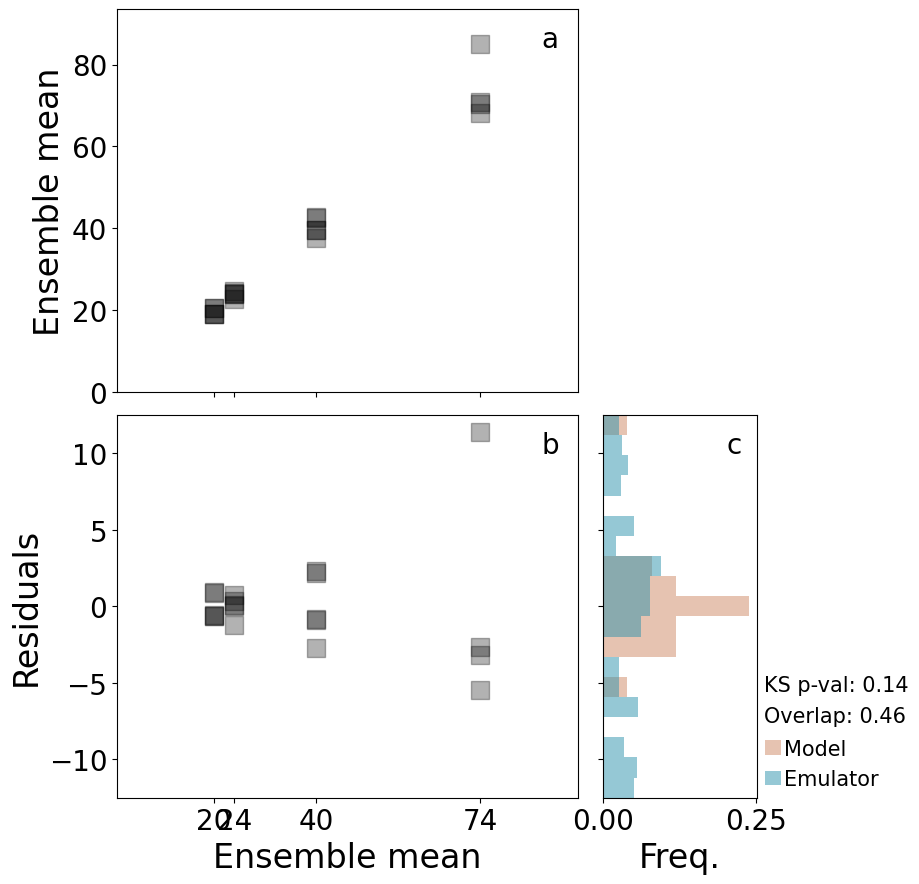

In [69]:
fig, kstat = plot_nugget_validation(tt_output, tt_loo_pred, transition_time_arr, tt_residuals)

### RWP mean

In [70]:
property_name = "rwp_mean"
rwp_residuals, rwp_ppe_variance = calculate_variance_vector(rwp_mean_arr)

Residuals:
 [[-0.10727624 -0.06831592  0.07393018  0.10166198         nan]
 [-0.31058535  0.4500659   0.21167968  0.09126854 -0.44242878]
 [-0.59880964 -0.36130717  0.28123876 -0.24389133  0.92276939]
 [ 0.10993019 -0.10496261 -0.07511619 -0.11053998  0.18068859]]

Ensemble variances:
 [np.float64(0.007994021824630047), np.float64(0.13697600939056945), np.float64(0.369799353412748), np.float64(0.018402923340626952)]
PPE variance vector:
 [0.00799402 0.36979935 0.01840292 0.01840292 0.00799402 0.01840292
 0.00799402 0.36979935 0.00799402 0.00799402 0.00799402 0.13697601
 0.13697601 0.00799402 0.01840292 0.00799402 0.36979935 0.00799402
 0.01840292 0.01840292 0.00799402 0.01840292 0.01840292 0.01840292
 0.36979935 0.36979935 0.00799402 0.36979935 0.01840292 0.00799402
 0.00799402 0.00799402 0.00799402 0.36979935]


In [41]:
np.savetxt(f"noise_files/nv_{property_name}.csv", ppe_variance, delimiter=',', header='nv', comments='')

In [71]:
rwp_output = np.loadtxt(f"data/output_data/{property_name}_output.csv", delimiter=',', skiprows=1)
rwp_loo_pred = np.loadtxt(f"predictions/loo/{property_name}_loo_pred.csv", delimiter=',', skiprows=1)

n1 sum:  9.359178764450558
n2 sum:  9.35917876445056


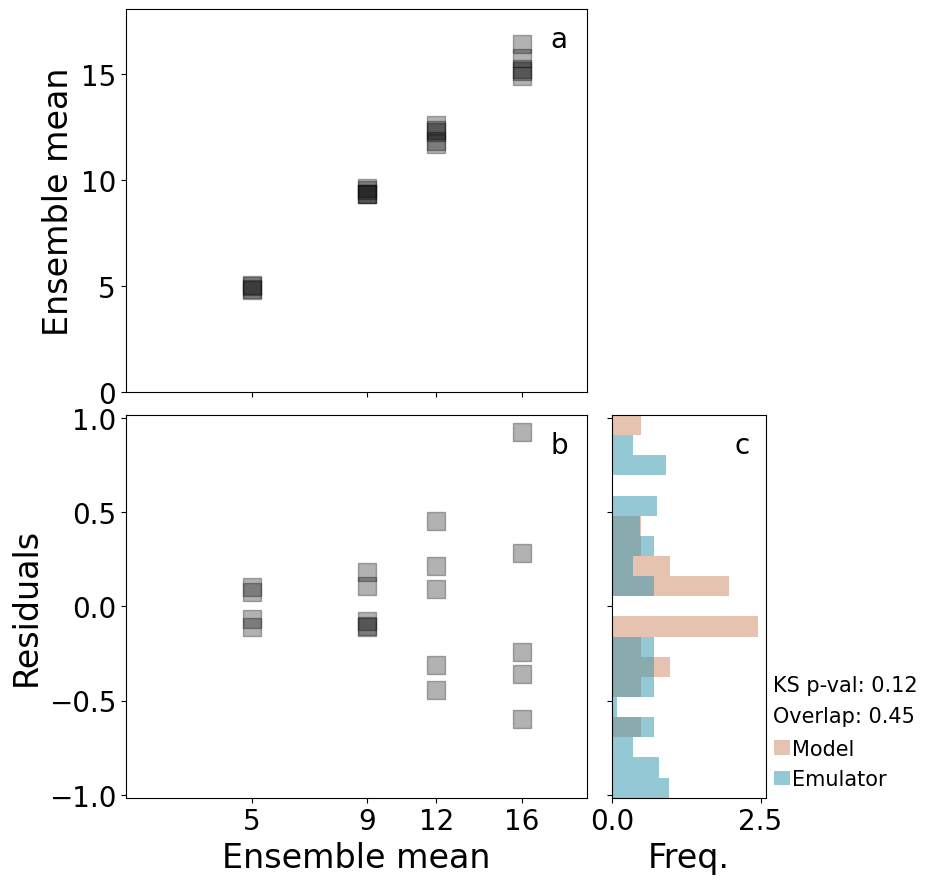

In [72]:
fig, kstat = plot_nugget_validation(rwp_output, rwp_loo_pred, rwp_mean_arr, rwp_residuals)